# Extract the tidal ellipse parameters from the surface velocity data

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from datetime import datetime
import os
from scipy import signal
from scipy.interpolate import interp1d
from scipy.interpolate import PchipInterpolator


from mycurrents import oceanmooring as om
from soda.utils.modvsobs import ModVsObs

from matplotlib import rcParams

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "12"
rcParams['axes.labelsize']='medium'


Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/home/mrayson/code/soda/soda/dataio/netcdfio.py:40: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  ncmeta = yaml.load(f)


In [2]:
%matplotlib notebook

In [3]:
def load_roms(romsfile, romsvar, zobs):
    roms = om.from_netcdf(romsfile, romsvar)

    # Interpolate ROMS onto observed depths
    Fi = PchipInterpolator(roms.Z, roms.y, axis=0)
    return om.OceanMooring(roms.t, Fi(zobs), zobs)

## Observation loading functions
def load_uv_BRB200(obsvar):
    uvfile = '/home/mrayson/group/mrayson/DATA/FIELD/KISSME/KISSME2017_RDI_QAQC_noerrvel.nc'
    group = 'BRB200_RDI_150_kHz_Quartermaster_16752'

    dso = xr.open_dataset(uvfile, group=group)

    Uobsraw = om.OceanMooring(dso.time.values, dso[obsvar].values, dso.zhat.mean(axis=1))
    zobs = -Uobsraw.Z - 10.
    xyin = np.array([dso.Longitude, dso.Latitude])

    return Uobsraw, zobs, xyin

def load_uv_SP250(obsvar):
    uvfile = '../DATA/UWA_KISSME_SP250_fixedheight_uv.nc'

    dso = xr.open_dataset(uvfile)
    dso
    Uobsraw = om.OceanMooring(dso.time.values, dso[obsvar].values, dso.depth.values)
    zobs = -Uobsraw.Z
    xyin = np.array([dso.X, dso.Y])
    return Uobsraw, zobs, xyin

def load_uv_ITFTIS(obsvar):
    uvfile = '../DATA/IMOS_Stack_Mooring_ITFTIS_201702_UV.nc'
    dso = xr.open_dataset(uvfile)
    zobs = (-dso['NOMINAL_DEPTH'] + dso['HEIGHT_ABOVE_SENSOR']).values
    Uobsraw = om.OceanMooring(dso.TIME.values, dso[obsvar].values, zobs)
    xyin = np.array([dso.LONGITUDE.values, dso.LATITUDE.values])
    print('dt: ',(dso.TIME.values[1]-dso.TIME.values[0]).astype('timedelta64[s]'))
    return Uobsraw, zobs, xyin

In [4]:
def load_velocity_mo(romsfile,  roms4dvarfile, obsvar, romsvar, t1, t2, loadfunc, resample=True):
    
    Uobsraw, zobs, xyin = loadfunc(obsvar)
    # Load the file w/out DA
    Umod = load_roms(romsfile, romsvar, zobs)
    Umod_da = load_roms(roms4dvarfile, romsvar, zobs)

    dt = (Umod.t[1] - Umod.t[0]).astype('timedelta64[s]').astype(float)

    # #Tobsraw = om.from_netcdf(Tfile, 'TEMP', group=None).clip(t1,t2)
    Uobs = Uobsraw.clip(t1,t2)
    if resample:
        Uobs=Uobs.resample(dt,ndt=1)


    mo_U = ModVsObs(Umod.t, Umod.y, Uobs.t, Uobs.y, \
                 Z=-zobs, units='m s-1', varname=romsvar, interpmodel=False)

    mo_U_da = ModVsObs(Umod_da.t, Umod_da.y, Uobs.t, Uobs.y, \
                 Z=-zobs, units='m s-1', varname=romsvar, interpmodel=False)
    
    return mo_U, mo_U_da

In [122]:
sitename = 'NP250'

roms4dvarfile = '../DATA/ROMS_4DVAR_station_{}_v3.nc'.format(sitename)
romsfile = '../DATA/ROMS_NL_station_{}_v3.nc'.format(sitename)


t1,t2 = np.datetime64('2017-04-03 00:00:00'),np.datetime64('2017-05-03 00:00:00')
mydatestr = 'Apr2017'

mo_U, mo_U_da = load_velocity_mo(romsfile,roms4dvarfile, 'u', 'u_eastward', t1,t2, load_uv_SP250)
mo_V, mo_V_da = load_velocity_mo(romsfile,roms4dvarfile, 'v', 'v_northward', t1,t2, load_uv_SP250)

/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: divide by zero encountered in true_divide
  ytmp2/=norm
/home/mrayson/code/soda/soda/utils/timeseries.py:437: RuntimeWarning: invalid value encountered in true_divide
  ytmp2/=norm


<IPython.core.display.Javascript object>


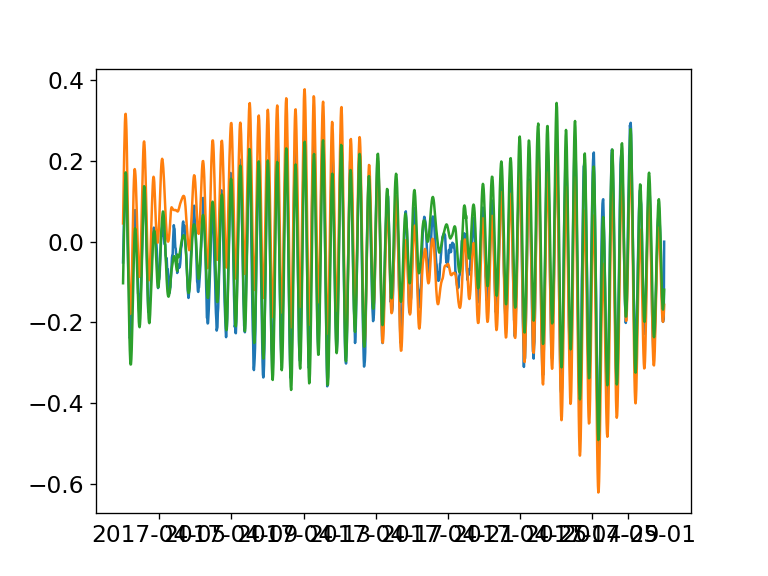

In [51]:
# Calculate the barotropic and baroclinic velocity from both mod and obs
mo_U.TSmod.y.shape, mo_U.TSobs.y.shape

def get_ubc(mo):
    ubar_obs = mo.TSobs.y.mean(axis=0)
    ubc_obs = mo.TSobs.y - ubar_obs

    ubar_mod = mo.TSmod.y.mean(axis=0)
    ubc_mod = mo.TSmod.y - ubar_mod
    return ubar_obs, ubc_obs, ubar_mod, ubc_mod

ubar_obs, ubc_obs, ubar_mod, ubc_mod = get_ubc(mo_U)
vbar_obs, vbc_obs, vbar_mod, vbc_mod = get_ubc(mo_V)
ubar_obs, ubc_obs, ubar_mod_da, ubc_mod_da = get_ubc(mo_U_da)
vbar_obs, vbc_obs, vbar_mod_da, vbc_mod_da = get_ubc(mo_V_da)

plt.figure()
plt.plot(mo_U.TSobs.t, ubar_obs)
plt.plot(mo_U.TSobs.t, ubar_mod)
plt.plot(mo_U.TSobs.t, ubar_mod_da)

In [19]:
from sfoda.utils.timeseries import window_index_time
from sfoda.utils.harmonic_analysis import harmonic_fit_array
from sfoda.suntans.suntides import ap2ep

In [94]:
def calc_harmonic_ellipse(time, u, v, windowsize, overlap):
    t = (time - np.datetime64('2000-01-01 00:00:00')).astype('timedelta64[s]').astype(float)

    # def calc_uv_ellipse()
    idx1,idx2 = window_index_time(mo_U.TSobs.t, windowsize, overlap)
    omega = 2*np.pi/(12.42*3600)

    u_re = []
    u_im = []

    v_re = []
    v_im = []
    
    tout = []
    for i1,i2 in zip(idx1,idx2):
        ui,vi,myt = u[i1:i2],v[i1:i2], t[i1:i2]
        
        idx = ~np.isnan(ui)
        
        _, a_re, a_im = harmonic_fit_array(ui[idx],myt[idx], [omega])
        u_re.append(a_re)
        u_im.append(a_im)

        _, a_re, a_im = harmonic_fit_array(vi[idx],myt[idx], [omega])
        v_re.append(a_re)
        v_im.append(a_im)
        
        tidx = int(i1 + 0.5*(i2-i1))
        tout.append(time[tidx])

    # Convert to amplitude and phase
    uamp = np.abs(np.array(u_re)+1j*np.array(u_im))
    uphs = np.angle(np.array(u_re)+1j*np.array(u_im))
    vamp = np.abs(np.array(v_re)+1j*np.array(v_im))
    vphs = np.angle(np.array(v_re)+1j*np.array(v_im))

    SEMA, SEMI, INC, PHS, ECC = ap2ep(uamp, uphs, vamp, vphs)
    
    return np.array(tout), SEMA, SEMI, INC, PHS, ECC 

In [113]:
windowsize=2*86400.
overlap = 1*86400.


tout, SEMA_bc_obs, SEMI_bc_obs, INC_bc_obs, PHS_bc_obs, ECC_bc_obs = \
    calc_harmonic_ellipse(mo_U.TSobs.t, ubar_obs, vbar_obs, windowsize, overlap)

tout, SEMA_bc_mod, SEMI_bc_mod, INC_bc_mod, PHS_bc_mod, ECC_bc_mod = \
    calc_harmonic_ellipse(mo_U.TSmod.t, ubar_mod, vbar_mod, windowsize, overlap)

tout, SEMA_bc_mod_da, SEMI_bc_mod_da, INC_bc_mod_da, PHS_bc_mod_da, ECC_bc_mod_da = \
    calc_harmonic_ellipse(mo_U_da.TSmod.t, ubar_mod_da, vbar_mod_da, windowsize, overlap)

/home/mrayson/code/sfoda/sfoda/utils/harmonic_analysis.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,X)


<IPython.core.display.Javascript object>


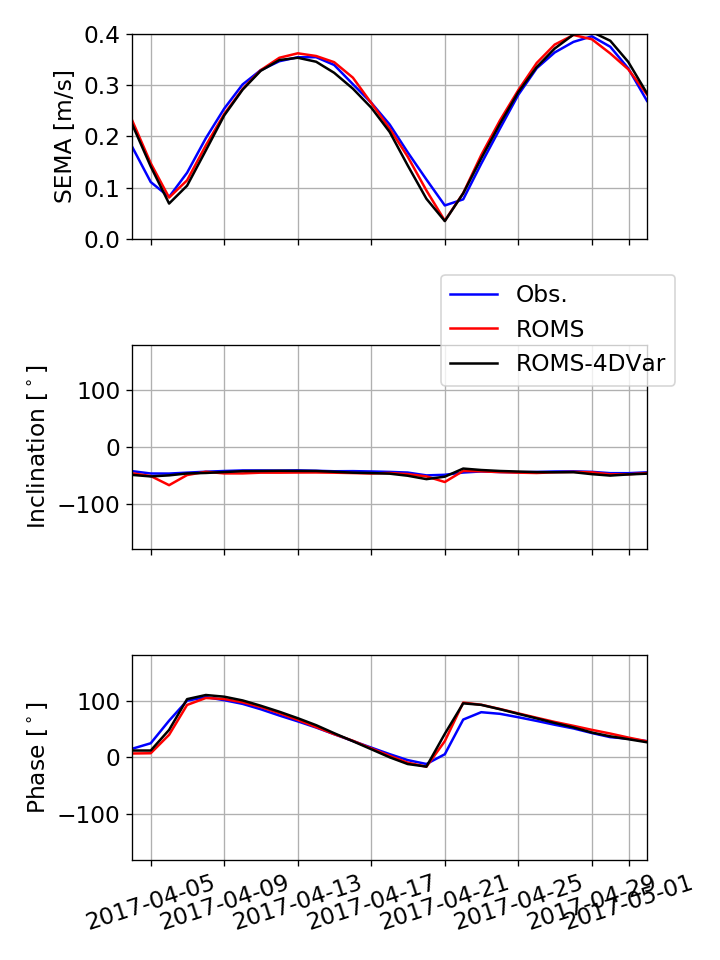

In [114]:
rad2deg = 180/np.pi
plt.figure(figsize=(6,8))
ax1=plt.subplot(311)
plt.plot(tout, SEMA_bc_obs,'b')
plt.plot(tout, SEMA_bc_mod,'r')
plt.plot(tout, SEMA_bc_mod_da,'k')
plt.ylim(0,0.4)
plt.xlim(tout[0],tout[-1])
plt.grid(b=True)
ax1.set_xticklabels([])
plt.ylabel('SEMA [m/s]')

ax2=plt.subplot(312)
plt.plot(tout, INC_bc_obs*rad2deg,'b')
plt.plot(tout, INC_bc_mod*rad2deg,'r')
plt.plot(tout, INC_bc_mod_da*rad2deg,'k')
plt.ylim(-180,180)
plt.xlim(tout[0],tout[-1])
plt.grid(b=True)
ax2.set_xticklabels([])
plt.ylabel('Inclination [$^\circ$]')
plt.legend(('Obs.','ROMS','ROMS-4DVar'), loc=(0.6,0.8))

ax3=plt.subplot(313)
plt.plot(tout, PHS_bc_obs*rad2deg,'b')
plt.plot(tout, PHS_bc_mod*rad2deg,'r')
plt.plot(tout, PHS_bc_mod_da*rad2deg,'k')
plt.ylim(-180,180)
plt.xlim(tout[0],tout[-1])
plt.grid(b=True)
plt.ylabel('Phase [$^\circ$]')
plt.xticks(rotation=18)
plt.tight_layout()

plt.savefig('../FIGURES/Ellipse_BT_SP250.png', dpi=150)

In [123]:
kk = 0
tout, SEMA_bc_obs, SEMI_bc_obs, INC_bc_obs, PHS_bc_obs, ECC_bc_obs = \
    calc_harmonic_ellipse(mo_U.TSobs.t, ubc_obs[kk,:], vbc_obs[kk,:], windowsize, overlap)

tout, SEMA_bc_mod, SEMI_bc_mod, INC_bc_mod, PHS_bc_mod, ECC_bc_mod = \
    calc_harmonic_ellipse(mo_U.TSmod.t, ubc_mod[kk,:], vbc_mod[kk,:], windowsize, overlap)

tout, SEMA_bc_mod_da, SEMI_bc_mod_da, INC_bc_mod_da, PHS_bc_mod_da, ECC_bc_mod_da = \
    calc_harmonic_ellipse(mo_U_da.TSmod.t, ubc_mod_da[kk,:], vbc_mod_da[kk,:], windowsize, overlap)

/home/mrayson/code/sfoda/sfoda/utils/harmonic_analysis.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,X)


<IPython.core.display.Javascript object>


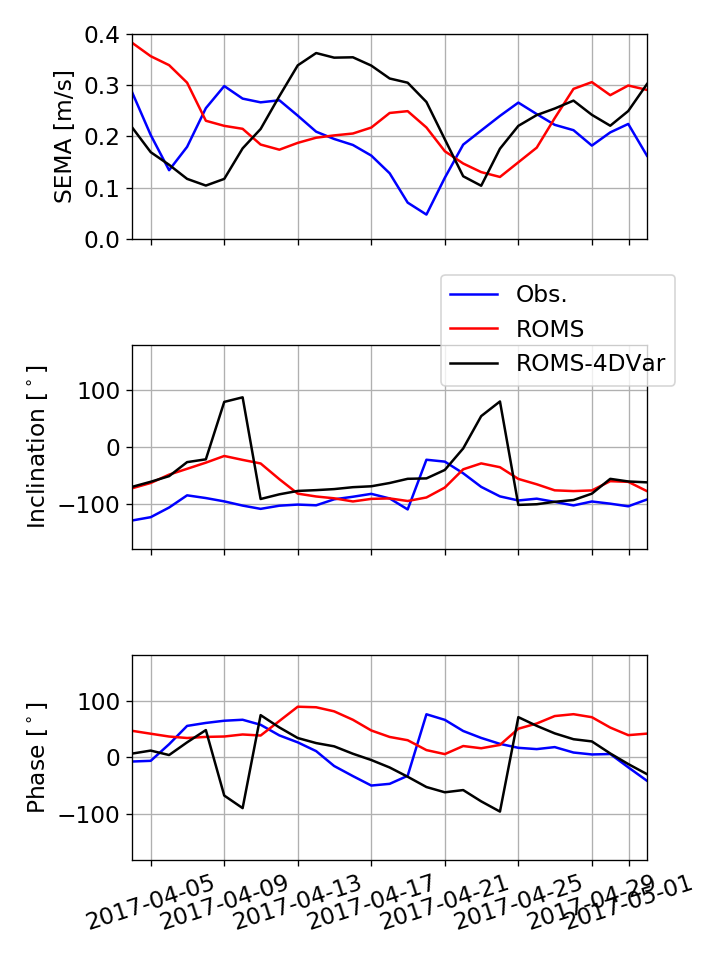

In [124]:
plt.figure(figsize=(6,8))
ax1=plt.subplot(311)
plt.plot(tout, SEMA_bc_obs,'b')
plt.plot(tout, SEMA_bc_mod,'r')
plt.plot(tout, SEMA_bc_mod_da,'k')
plt.ylim(0,0.4)
plt.xlim(tout[0],tout[-1])
plt.grid(b=True)
ax1.set_xticklabels([])
plt.ylabel('SEMA [m/s]')

ax2=plt.subplot(312)
plt.plot(tout, INC_bc_obs*rad2deg,'b')
plt.plot(tout, INC_bc_mod*rad2deg,'r')
plt.plot(tout, INC_bc_mod_da*rad2deg,'k')
plt.ylim(-180,180)
plt.xlim(tout[0],tout[-1])
plt.grid(b=True)
ax2.set_xticklabels([])
plt.ylabel('Inclination [$^\circ$]')
plt.legend(('Obs.','ROMS','ROMS-4DVar'), loc=(0.6,0.8))

ax3=plt.subplot(313)
plt.plot(tout, PHS_bc_obs*rad2deg,'b')
plt.plot(tout, PHS_bc_mod*rad2deg,'r')
plt.plot(tout, PHS_bc_mod_da*rad2deg,'k')
plt.ylim(-180,180)
plt.xlim(tout[0],tout[-1])
plt.grid(b=True)
plt.ylabel('Phase [$^\circ$]')
plt.xticks(rotation=18)
plt.tight_layout()

plt.savefig('../FIGURES/Ellipse_BC_SP250_surface.png', dpi=150)